# Cross-Validation

Cross-validation is a step where we take our training sample and further divide it in many folds, as in the illustration here:

```{image} ./img/feature_5_fold_cv.jpg
:alt: 5-fold
:width: 400px
:align: center
```

As we talked about in the last chapter, cross-validation allows us to test our models outside the training data more often. This trick reduces the likelihood of overfitting and improves generalization: It _should_ improve our model's performance when we apply it outside the training data.

```{margin}
Illustration: If you emulate the simple folding method as depicted in the above graphic for stock return data, some folds will end up testing your model on data from _before_ the periods where the model was estimated!
```

```{warning}
I say "it _should_ improve our model's performance" because the exact manner in which you create the folds matters! 

See the tip below.
```

## Basic example

Like before, let's first load the data. Notice I consolidated the import lines at the top. 


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

url        = 'https://github.com/LeDataSciFi/data/blob/main/Fannie%20Mae/Fannie_Mae_Plus_Data.gzip?raw=true'
fannie_mae = pd.read_csv(url,compression='gzip').dropna()
y          = fannie_mae.Original_Interest_Rate
fannie_mae = (fannie_mae
                  .assign(l_credscore = np.log(fannie_mae['Borrower_Credit_Score_at_Origination']),
                          l_LTV = np.log(fannie_mae['Original_LTV_(OLTV)']),
                         )
              .iloc[:,-11:] # limit to these vars for the sake of this example
             )


And, like before, we then split off some of the data into a testing sample. 

_For the sake of simplicity (laziness?), let's just reuse the `train_test_split` approach from the last page._

In [2]:
rng = np.random.RandomState(0) # this helps us control the randomness so we can reproduce results exactly
X_train, X_test, y_train, y_test = train_test_split(fannie_mae, y, random_state=rng)

````{dropdown} **Digression. Read this after you read the "Choosing what kind of CV folds to use" section below.**

Below, we introduce some of the conceptual issues with how you create folds for CV. Once you read that, come back and revisit this `test_train_split` code above, because the same considerations for how we choose folds within a CV apply to how we split off our testing sample.

[This page](https://scikit-learn.org/stable/modules/cross_validation.html#using-cross-validation-iterators-to-split-train-and-test) says `train_test_split` uses [ShuffleSplit](https://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split). This method does not divide by time or any group type. 

```{dropdown} Q: Does this Fannie Mae data need special attention to how we divide it up?

A question to ponder, in class perhaps...

```

If you want to use any other CV iterators to divide up your sample, you can. Here is one:

```python
# Replace "GroupShuffleSplit" with your CV of choice,
# and update the contents of split() as needed.

train_idx, test_idx = next(
    GroupShuffleSplit(random_state=7).split(X, y, groups)
)
X_train, X_test, y_train, y_test = X[train_idx], X[train_idx], y[test_idx], y[test_idx]
```

You don't even need to use a built-in CV method to create your holdout data. Here is a simple approach that works in many settings:

```python
# test on the last year of data

train_idx, test_idx = X[X['year']<X['year'].max()], 
                      X[X['year']=X['year'].max()]
X_train, X_test, y_train, y_test = X[train_idx], X[train_idx], y[test_idx], y[test_idx]
```

````

## Set up the CV

```{margin} 
_Note: **Your estimator will actually be a "pipeline" object.** ([covered in detail on the next page](04e_pipelines)) A pipeline object tells sk-learn to apply a series of steps to the data (preprocessing, etc.) and always ends with a model to estimate._
```

Sk-learn makes cross-validation pretty easy. We use the `cross_validate("estimator",X_train,y_train,cv,scoring,...)` function ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)) which, under the hood, will 
1. Create folds in X_train and y_train using whatever method you put in the `cv` parameter. For each fold, it will create a smaller "training partition" and "validation partition" like in the figure at the top of this page. 
1. For each fold, it will
    1. Fit your "estimator" on the smaller training partition it creates for that fold (as if you ran `estimator.fit(X_trainingpartition,y_trainingpartition)`). 
    1. Use that fitted estimator on the validation partition (as if you ran `estimator.predict(X_validationpartition)`). 
    1. Score those predictions with the function(s) you put in `scoring`.
1. Output a dictionary object with performance data for each fold.

```{important}
So, to use `cross_validate()`, you need to decide on and set up:

1. Your preferred folding method (and number of folds)
1. Your estimator (or pipeline ending in an estimator)
1. Your scoring method(s) 
```

The code _can_ be this simple:

In [3]:
from sklearn.model_selection import KFold, cross_validate

cv    = KFold(5)                       # pick and set up fold method
ridge = Ridge(alpha=1.0)               # set up model/estimator
cross_validate(ridge,
               X_train,y_train, cv=cv, 
               scoring='r2')           # tell it the scoring method here

{'fit_time': array([0.0181005, 0.       , 0.       , 0.       , 0.       ]),
 'score_time': array([0.        , 0.01563931, 0.        , 0.        , 0.        ]),
 'test_score': array([0.90789446, 0.89926394, 0.900032  , 0.90479828, 0.90327986])}

```{note} 
Wow, that was easy! Just 3 lines of code (and an import).
```

And we can output test score statistics like:

In [4]:
scores = cross_validate(ridge, X_train, y_train, cv=cv, scoring="r2")
print(scores["test_score"].mean())  # scores is just a dictionary
print(scores["test_score"].std())

0.9030537085469961
0.0031629307869794876


## Choosing what kind of CV folds to use

What should we put in the `cv = ?` line of code?

It depends on the dataset:

- **IID data**: If we have a dataset with one observation per unit and all observations are at either the same time, or if time can be ignored:
    - `KFold()` and `ShuffleSplit()`
    - If you have a [classification task](03e_whichModel) with imbalanced labels, use `StratifiedKFold()` and `StratifiedShuffleSplit()`
- **Grouped, time-independent data**: If time can be ignored or there is only one time period, and you have multiple observations for each unit ("groups"), your goal is likely to find out if a model trained on a particular set of groups generalizes well to the unseen groups:
    - `GroupKFold()` and `GroupShuffleSplit`
    - If you have a [classification task](03e_whichModel) with imbalanced labels, use `StratifiedGroupKFold()` 
- **If your data and/or task is time dependent:** E.g. predicting stock returns, any setting where the choice depends on prior choices and outcomes
    - **You must ensure that the validation partitions are subsequent to the training sample.**
    - Rarely: If you have a simple time series dataset (one observation for each time), use the built-in `TimeSeriesSplit()`  
    - Usually: If you have a cross-sectional panel (multiple observations for each time), build a custom splitter to generate your folds.

```{tip}
**[This page should be your first reference to learn about the CV splitting functions listed above.](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators)** 
```

## Custom CV folds

You can explicitly design and create customer CV folds to suit your problem. [The `cross_validation()` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) says that `cv` can be "An iterable yielding (train, test) splits as arrays of indices."

Let's use this example: 

```python
cv_custom = [([0,1],[2]),
             ([0,1,2],[3]),
             ([0,1,2,3],[4])]

cross_validate(ridge,
               X_train,y_train, cv=cv_custom, 
               scoring='r2')  
```

`cv_custom` is a list (lists are an "iterable" object) with 3 elements, so our cross validation will have 3 folds. 
1. The first fold is given by the first element: `([0,1],[2])`, which says the training data is rows 0 and 1, and the validation is done on row 2.
1. In the second fold, train on rows 0 to 2, and validate on row 3.
1. And so on.

## Code for rolling OOS testing (v0)

```{important}
The code below is _**almost**_ plug-and-play! (But not quite!) 
```

```{margin}
1. Train on year 1, and predict outcomes in year 2.
1. Then train on years 1 and 2, and predict outcomes in year 3.
1. Then train on years 1  -  3, and predict outcomes in year 4.
1. Then train on years 1  -  4, and predict outcomes in year 5.
1. ...
1. Then train on years 1  -  16, and predict outcomes in year 17.
```

One procedure to do rolling OOS testing was introduced [on this page](03c1_OOS), and I copied it here in the sidebar. It's a common choice that works well in many settings. It works when you have many firms or units (whether each unit has one or multiple observations per year), or even with a single time series![^oneseries] And it can be adjusted to other units of time (monthly, weekly, decades), or only every few units of time.

[^oneseries]: You could do `TimeSeriesSplit()`, but if you have 20 years of daily trading data, there are potentially ~500 possible splits! That will be slow when you evaluate a bunch of models a bunch of times! The procedure above reduces that greatly.

The code below implements it and can be used with appropriate adjustments for your setting. 

```python
# adjust the inside of "groupby()" to your df/problem, pick other parameters

time_groups               = X_train.groupby(X_train['DATE'].dt.year).groups 
min_periods_in_train      = 5
training_expanding_window = True

# shouldn't need to adjust this code: 

sorted_groups = [list(value) for (key, value) in sorted(time_groups.items())]

if training_expanding_window:

    cv = [([i for g in sorted_groups[:y] for i in g],sorted_groups[y]) 
            for y in range(min_periods_in_train , len(sorted_groups))]

else:
    
    cv = [([i for g in sorted_groups[y-min_periods_in_train:y] for i in g],sorted_groups[y]) 
            for y in range(min_periods_in_train, len(sorted_groups))]
```

````{tip}
Extra credit: Convert the code above into a function for the community codebook! 

Something like:

```python
def rolling_oos_cv(???): # you need to decide on arguments
    ??? 
    return cv
```

Considerations/bonus:
1. ESSENTIAL: How should the user specify the time dimensions to groupby? What if they want to use months, weeks, etc. instead of years?
1. EASY BONUS: Can the user ask for multiple time periods in the validation sets? E.g. predict the next two years?
1. HARDER BONUS: Can the user ask to skip some folds? E.g. if they group the data by months, but only do the training and prediction for the first month each year?
````

## Code for rolling OOS testing (v1)

The code above works. It lacks some features, and until a classmate codes it up into a nice function, it requires copy-pasting all of the code I wrote, and adjusting it.

As of mid-2022, someone has finally made a function that looks like a promising solution. [Here is the documentation for GroupTimeSeriesSplit.](https://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/) However, it's new and has some quirks. 

Here is an illustration of how it divides up the sample. First, I'll create a simple dataset we can look at. Notice we have several firms in many years.

In [5]:
import pandas as pd

df = pd.DataFrame({'year':[2000,2000,2000,2001,2001,2002,2002,2002,2002,2003,2004,2004,2006],
                   'firm':[1,2,3,1,2,1,2,3,4,4,4,5,5],
                   'X':   [0,4,5,2,5,7,2,4,4,9,8,9,8],
                   'y':   [0,0,1,1,1,1,0,0,1,1,0,1,0]
                  })
display(df.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12
year,2000,2000,2000,2001,2001,2002,2002,2002,2002,2003,2004,2004,2006
firm,1,2,3,1,2,1,2,3,4,4,4,5,5
X,0,4,5,2,5,7,2,4,4,9,8,9,8
y,0,0,1,1,1,1,0,0,1,1,0,1,0


`GroupTimeSeriesSplit()` correctly splits up the sample:

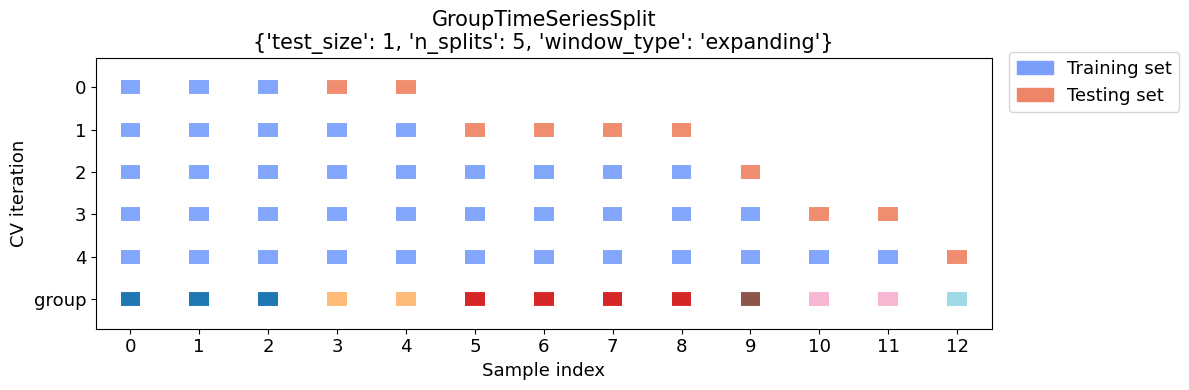

In [6]:
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit, plot_splits
cv_args = {'test_size':1, 'n_splits':5,'window_type':'expanding'}
plot_splits(df.X, df.y, df.year, **cv_args)

Using it is easy: 
1. Replace the `cv=` with `GroupTimeSeriesSplit()` and the parameters you want.
1. Add `groups=` to cross_validate, and it should be the variable containing the time info.

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from mlxtend.evaluate import GroupTimeSeriesSplit

cv      = GroupTimeSeriesSplit(test_size=1, 
                               n_splits=5, 
                               window_type='expanding') # set up fold method
clf     = DummyClassifier(strategy="most_frequent")     # set up model/estimator

cross_validate(clf,
               df.X, df.y,
               cv=cv,
               groups=df.year, 
               scoring="accuracy")["test_score"]        # for this page, just print results

array([0. , 0.5, 1. , 0.5, 0. ])

## Next step: Pipelines

The model above 
- Only uses a few continuous variables: what if we want to include other variable types (like categorical)?
- Uses the variables as given: ML algorithms often need you to transform your variables
- Doesn't deal with any data problems (e.g. missing values or outliers)
- Doesn't create any interaction terms or polynomial transformations
- Uses every variable I give it: But if your input data had 400 variables, you'd be in danger of overfitting!

At this point, you are capable of solving all of these problems. (For example, you could clean the data in pandas.)

**But for our models to be robust to evil monsters like "data leakage", we need the fixes to be done within pipelines.** 